In [1]:
!git clone https://github.com/martha92/babycry.git

fatal: destination path 'babycry' already exists and is not an empty directory.


In [2]:
!rm /content/babycry/Data/Audio_augmentation/data_augment.py

rm: cannot remove '/content/babycry/Data/Audio_augmentation/data_augment.py': No such file or directory


Streaming output truncated to the last 5000 lines.
Epoch 1002/3500
7/7 [==============================] - 0s 32ms/step - loss: 0.0505 - accuracy: 0.9796 - val_loss: 0.6665 - val_accuracy: 0.8600 - lr: 2.2518e-07
Epoch 1003/3500
7/7 [==============================] - 0s 29ms/step - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.6680 - val_accuracy: 0.8600 - lr: 2.2518e-07
Epoch 1004/3500
7/7 [==============================] - 0s 27ms/step - loss: 0.0481 - accuracy: 0.9796 - val_loss: 0.6686 - val_accuracy: 0.8600 - lr: 2.2518e-07
Epoch 1005/3500
7/7 [==============================] - 0s 28ms/step - loss: 0.0309 - accuracy: 0.9949 - val_loss: 0.6705 - val_accuracy: 0.8600 - lr: 2.2518e-07
Epoch 1006/3500
7/7 [==============================] - 0s 32ms/step - loss: 0.0313 - accuracy: 0.9898 - val_loss: 0.6701 - val_accuracy: 0.8600 - lr: 2.2518e-07
Epoch 1007/3500
7/7 [==============================] - 0s 30ms/step - loss: 0.0726 - accuracy: 0.9643 - val_loss: 0.6623 - val_accuracy: 0.8600 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


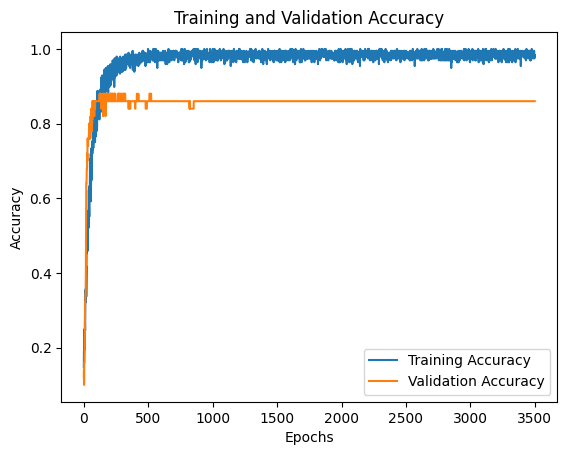

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import matplotlib.pyplot as plt

# Define your folder structure
data_dir = '/content/babycry/Data/Audio_augmentation'
classes = os.listdir(data_dir)

def load_and_preprocess_data(data_dir, classes, target_length=16000, size=128):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            audio_data, _ = librosa.load(file_path, sr=None)
            # Perform feature extraction
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=target_length)
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=target_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=target_length)
            tonnetz = librosa.feature.tonnetz(y=audio_data, sr=target_length)

            # Resize features to the same shape
            mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (size, size))
            chroma = resize(np.expand_dims(chroma, axis=-1), (size, size))
            spectral_contrast = resize(np.expand_dims(spectral_contrast, axis=-1), (size, size))
            tonnetz = resize(np.expand_dims(tonnetz, axis=-1), (size, size))

            # Concatenate all features
            features = np.concatenate([mel_spectrogram, chroma, spectral_contrast, tonnetz], axis=-1)

            data.append(features)
            labels.append(i)

    return np.array(data), np.array(labels)

# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Data normalization
# mean = np.mean(X_train)
# std = np.std(X_train)
# X_train = (X_train - mean) / std
# X_test = (X_test - mean) / std

# Create a simplified neural network model with dropout for regularization
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.9)(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.00001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model with data augmentation and callbacks for early stopping, learning rate reduction, and training evaluation
batch_size = 32
epochs = 3500

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=50, min_lr=1e-12)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_test), callbacks=[ reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('audio_classification_simple_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
